## Library

In [ ]:
import pandas as pd
import torch
from torch.utils.data import Dataset,DataLoader
from transformers import BertTokenizer,BertModel
from torch import nn
from tqdm import trange
import transformers
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt

## Load and Preprocess

In [ ]:
train_csv=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/Train.csv')

valid_csv=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/Valid.csv')

test_csv=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/archive/Test.csv')


In [ ]:
#shape of each data part
print(f"train:{train_csv.shape},test:{test_csv.shape},valid:{valid_csv.shape}")

train:(40000, 2),test:(5000, 2),valid:(5000, 2)


In [ ]:
#there is missing data in own data?
True in train_csv.isnull(),True in test_csv.isnull(),True in valid_csv.isnull()
#train,test,valid

# ?-> NO

(False, False, False)

In [ ]:
#build dataset
class build_dataset(Dataset):
    def __init__(self,data):
        self.data=data

    def __len__(self):
        return len(self.data)


    def __getitem__(self, index):

        #get text and label

        text=str(self.data['text'][index])
        label = torch.tensor(self.data['label'][index], dtype=torch.long)


        return label,text




#label,text


In [ ]:
# all classes we have
set(train_csv[:10000]['label'])

{0, 1}

Because of limited resources, I could not use all the data for training.

In [ ]:
#build dataset
data_train=build_dataset(train_csv[:1000])
data_valid=build_dataset(valid_csv[:100])
data_test=build_dataset(test_csv[:100])

#build dataloader
train_loader=DataLoader(data_train,batch_size=10,shuffle=True)
valid_loader=DataLoader(data_valid,batch_size=10,shuffle=True)
test_loader=DataLoader(data_test,batch_size=10,shuffle=True)

In [ ]:
#our device for training
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')



## functional matrix

I want the base model to be obtained via a model class and then combined with a classifier block, and finally generate the main model.

In [ ]:
class model(torch.nn.Module):
    def __init__(self,model,tooken,out_shape,n_class,device):

        super().__init__()
        #model and tokenizer have to be on the same device
        self.model=model.to(device)
        self.token=tooken.to(device)
        #classifier block
        self.classifier=nn.Sequential(
            nn.Linear(out_shape,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128,74),
            nn.ReLU(),
            nn.Linear(74,n_class)
            )
    def forward(self,text):
        inputs=self.token(
            list(text),
            return_tensors='pt',
            padding=True, truncation=True)

        #inputs=inputs.to(device)
        outputs=self.model(input_ids=inputs['input_ids'],
                           attention_mask=inputs['attention_mask'])
        #get cls token for classification
        cls=outputs.last_hidden_state[:,0,:]


        idx=self.classifier(cls)


        return idx

In this step, the downloaded weights are applied to the model architecture.

In [ ]:
def weight_add_function(model,adress_weight):
  return model.load_state_dict(torch.load(adress_weight))

A confusion matrix was used to evaluate and present the model’s performance.

In [ ]:

def confu(model, data_loader, display_labels=["NEG",'POS']):

  true_labels = []
  predicted_labels = []
  acc_list=[]

  model.eval()
  with torch.no_grad():
      #read data
      for labels, texts in data_loader:
          #predict data
          outputs = model(texts)
          #get predicted labels(index)
          predicted = torch.argmax(outputs, 1)
          #make inputs data of confusing matrix
          true_labels.extend(labels.cpu().numpy())
          predicted_labels.extend(predicted.cpu().numpy())

  cm = confusion_matrix(true_labels, predicted_labels)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
  #accuracy
  accuracy = np.trace(cm) / np.sum(cm)
  ax = disp.plot(cmap=plt.cm.Blues)
  ax.ax_.set_title(f"Accuracy: {accuracy:.2f}")

  plt.show()


plot for show traing process on plots

In [ ]:
def show_plot(train_list_loss,train_list_cross):

    epochs=range(1,len(train_list_loss)+1)

    plt.plot(epochs,train_list_loss,'b',label='Training Loss')
    plt.plot(epochs,train_list_cross,'r',label='Training Cross Entropy Loss')
    plt.title('Training Loss and Cross Entropy Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

The training function uses the cross-entropy loss function and the Adam optimizer, and the training loss is recorded during training to show the progress.

In [ ]:
def train_model(model,train_loader,epochs,jump,lr):
    
    #my loss function
    loss_fn=nn.CrossEntropyLoss()
    #Adam
    optimizer=torch.optim.Adam(model.parameters(),lr=lr)

    train_list_loss=[]
    train_list_cross=[]

    #start training
    model.train()

    for epoch in range(epochs):
        total_loss=0

        for labels,texts in train_loader:
            #labels and text have to be in same device
            labels=labels.to(device)
            texts=texts.to(device)

            optimizer.zero_grad()
            #predict model
            outputs=model(texts)
            loss=loss_fn(outputs,labels)
            loss.backward()
            optimizer.step()
            total_loss+=loss.item()

        avg_loss=total_loss/len(train_loader)
        #this predict and loss is for show training precess
        predict=model(texts)
        loss_cross=loss_fn(predict,labels)
        print(f"epoch:{epoch},loss:{avg_loss},loss_cross:{loss_cross.item()}")

        if epoch%jump ==0:
          # do you want to download model now ?
          # y = yes , n = no , b = break
          y_or_n=input('Do you want it?[y],[n],[b]')
          if y_or_n=='y':
            torch.save(model.state_dict(), f"weights_epoch_{epoch+1}.pth")
          elif y_or_n=='b':
            break
          else:
            pass


        train_list_loss.append(avg_loss)
        train_list_cross.append(loss_cross.item())

    return train_list_loss,train_list_cross


## Base Bert

downloaded model and tokenizer

In [ ]:
model_bert=BertModel.from_pretrained('bert-base-uncased')
tookenizer_bert=BertTokenizer.from_pretrained('bert-base-uncased')



In [ ]:
main_bert=model(model=model_bert,tooken=tookenizer_bert,out_shape=768,n_class=2,device=device)

Since the dataset I’m working with is a well-known dataset and doesn’t have much complexity, and also because I don’t have sufficient to training resources for this task, I freeze BERT during training. However, if you want to train BERT, I have written a few commented lines of code that you can uncomment and use, which will make BERT trainable in some parts.

In [ ]:
for parameter in main_bert.model.parameters():
    parameter.requires_grad = False




#for parameter in main_bert.model.encoder.layer[6].attention.output.parameters():
#    parameter.requires_grad = True


#for parameter in main_bert.model.encoder.layer[7].parameters():
#    parameter.requires_grad = True


for parameter in main_bert.classifier.parameters():
    parameter.requires_grad = True








In [ ]:
data_test.data.shape


(100, 2)

model have to be in same device with data and oder parameters

In [ ]:
main_bert=main_bert.to(device)

In [ ]:
train_loss,cross_loss=train_model(main_bert,train_loader,20,5,2e-5)



epoch:0,loss:0.23621068004518747,loss_cross:0.07153134047985077
Do you want it?[y],[n],[b]n
epoch:1,loss:0.23221311315894128,loss_cross:0.1788807362318039
epoch:2,loss:0.24087762948125602,loss_cross:0.02698914147913456
epoch:3,loss:0.2466762715578079,loss_cross:0.1277375966310501
epoch:4,loss:0.2339600508660078,loss_cross:0.27465611696243286
epoch:5,loss:0.23227498654276132,loss_cross:0.22351765632629395
Do you want it?[y],[n],[b]n
epoch:6,loss:0.22333734780550002,loss_cross:0.42499953508377075
epoch:7,loss:0.2223574642650783,loss_cross:0.24607649445533752
epoch:8,loss:0.22008747316896915,loss_cross:0.027525585144758224
epoch:9,loss:0.22639035677537322,loss_cross:0.15498265624046326
epoch:10,loss:0.22109601229429246,loss_cross:0.04212894290685654
Do you want it?[y],[n],[b]n
epoch:11,loss:0.2264838912896812,loss_cross:0.2560604214668274
epoch:12,loss:0.22836402926594018,loss_cross:0.22750449180603027
epoch:13,loss:0.22643510807305575,loss_cross:0.0415063202381134
epoch:14,loss:0.2093128

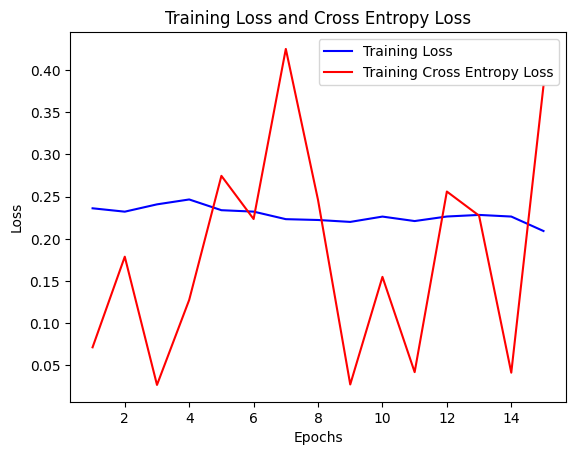

In [ ]:
show_plot(train_loss,cross_loss)

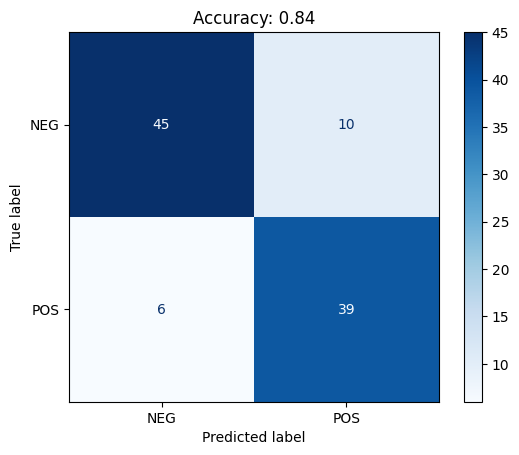

In [ ]:
confu(main_bert, valid_loader)

Although the model achieved relatively good accuracy, the learning curve (blue line) did not show significant improvement over time. Moreover, the cross-entropy loss (red line) indicates unstable and noisy behavior, suggesting that the model tends to guess predictions and is not fully reliable

## Albert base

download albert model and tokenizer

In [ ]:
from transformers import AlbertTokenizer, AlbertModel

tookenizer_albert = AlbertTokenizer.from_pretrained("albert-base-v2")
model_albert = AlbertModel.from_pretrained("albert-base-v2")

model structure

In [ ]:
model_albert

AlbertModel(
  (embeddings): AlbertEmbeddings(
    (word_embeddings): Embedding(30000, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0, inplace=False)
  )
  (encoder): AlbertTransformer(
    (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
    (albert_layer_groups): ModuleList(
      (0): AlbertLayerGroup(
        (albert_layers): ModuleList(
          (0): AlbertLayer(
            (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (attention): AlbertSdpaAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (attention_dropout): Dropout(p=0, inplace=False)
  

In [ ]:
#finally model
main_albert=model(model=model_albert,tooken=tookenizer_albert,out_shape=768,n_class=2,device=device)

In [ ]:
for parameters in main_albert.model.parameters():
  parameters.requires_grad=False


#for parameters in main_albert.model.encoder.embedding_hidden_mapping_in.parameters():
#  parameters.requires_grad=True

#for parameters in main_albert.model.encoder.albert_layer_groups[0].albert_layers[0].ffn.parameters():
#  parameters.requires_grad=True



#for parameters in main_albert.model.encoder.albert_layer_groups[0].albert_layers[0].ffn_output.parameters():
#  parameters.requires_grad=True



for parameters in main_albert.classifier.parameters():
  parameters.requires_grad=True

In [ ]:
main_albert_model=main_albert.to(device)

In [ ]:
train_loss,cross_loss=train_model(main_albert_model,train_loader,20,2,2e-5)



epoch:0,loss:0.6775571542978287,loss_cross:0.6426497101783752
epoch:1,loss:0.6331969058513641,loss_cross:0.6334064602851868
epoch:2,loss:0.5690992629528046,loss_cross:0.49610239267349243
epoch:3,loss:0.49478874742984774,loss_cross:0.434450626373291
epoch:4,loss:0.428272365629673,loss_cross:0.4100835919380188
epoch:5,loss:0.3811211597919464,loss_cross:0.28668779134750366
epoch:6,loss:0.3467708395421505,loss_cross:0.18928450345993042
epoch:7,loss:0.3154101999104023,loss_cross:0.5209805965423584
epoch:8,loss:0.2917234917730093,loss_cross:0.10715882480144501
epoch:9,loss:0.2737333492934704,loss_cross:0.2819969952106476
epoch:10,loss:0.25612804137170314,loss_cross:0.23028972744941711
epoch:11,loss:0.24925271846354008,loss_cross:0.4258507788181305
epoch:12,loss:0.23489436082541942,loss_cross:0.18902797996997833
epoch:13,loss:0.2274020660854876,loss_cross:0.09697623550891876
epoch:14,loss:0.21599657487124205,loss_cross:0.22238008677959442
epoch:15,loss:0.21891719417646527,loss_cross:0.1446493

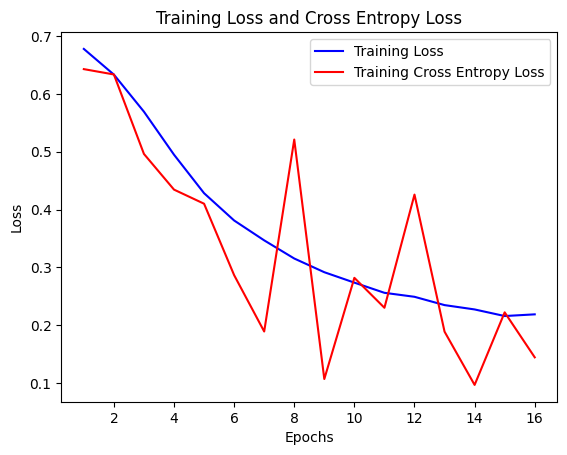

In [ ]:
show_plot(train_loss,cross_loss)

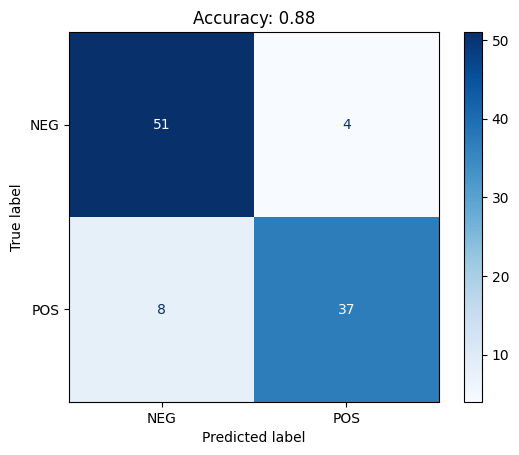

In [ ]:
confu(main_albert_model,valid_loader)

As you can see, the loss during training (the blue line) has decreased well over the course of training, and likewise the cross-entropy loss (the red line). It is indeed a bit noisy, but it is still acceptable at this stage and compared to the other models.

## Robert base

In [ ]:
tokenizer_robert = transformers.RobertaTokenizer.from_pretrained("roberta-base")
model_robert = transformers.RobertaModel.from_pretrained("roberta-base")

In [ ]:
main_robert=model(model=model_robert,tooken=tokenizer_robert,out_shape=768,n_class=2,device=device)

In [ ]:
for parameters in main_robert.parameters():
  parameters.requires_grad=False



#for parameters in main_robert.model.encoder.layer[5].intermediate.parameters():
#  parameters.requires_grad=True



#for parameters in main_robert.model.encoder.layer[7].attention.parameters():
#  parameters.requires_grad=True




for parametrs in main_robert.classifier.parameters():
  parametrs.requires_grad=True


In [ ]:
main_robert

model(
  (model): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((

In [ ]:
main_robert_model=main_robert.to(device)

In [ ]:
train_loss_robert,train_cross_robert=train_model(main_robert_model,train_loader,20,4,2e-5)

epoch:0,loss:0.6099025642871857,loss_cross:0.5621474385261536
epoch:1,loss:0.6013319939374924,loss_cross:0.542111873626709
epoch:2,loss:0.5967698377370835,loss_cross:0.5416284799575806
epoch:3,loss:0.5799354621767998,loss_cross:0.5598790049552917
epoch:4,loss:0.5766924527287484,loss_cross:0.5334364175796509
epoch:5,loss:0.5620693248510361,loss_cross:0.5203772783279419
epoch:6,loss:0.5477749836444855,loss_cross:0.5451418161392212
epoch:7,loss:0.5395604941248894,loss_cross:0.4827512204647064
epoch:8,loss:0.5268614801764488,loss_cross:0.40535879135131836
epoch:9,loss:0.5110880368947983,loss_cross:0.4815400540828705
epoch:10,loss:0.5003068113327026,loss_cross:0.6283212900161743
epoch:11,loss:0.4870170885324478,loss_cross:0.42104655504226685
epoch:12,loss:0.47692481845617296,loss_cross:0.5034135580062866
epoch:13,loss:0.46180763870477676,loss_cross:0.4038822650909424
epoch:14,loss:0.4666213476657867,loss_cross:0.4741055369377136
epoch:15,loss:0.45015034794807435,loss_cross:0.596629798412323

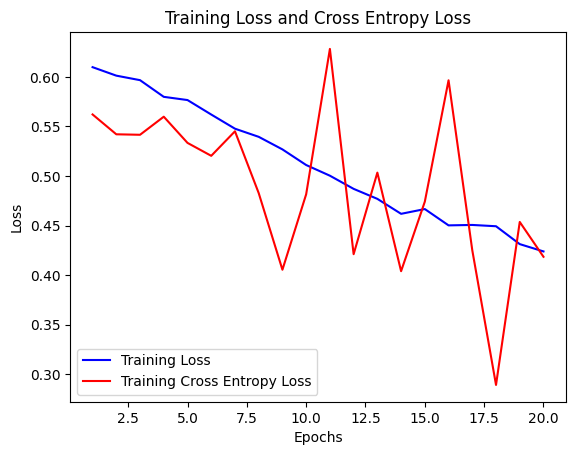

In [ ]:
show_plot(train_loss_robert,train_cross_robert)

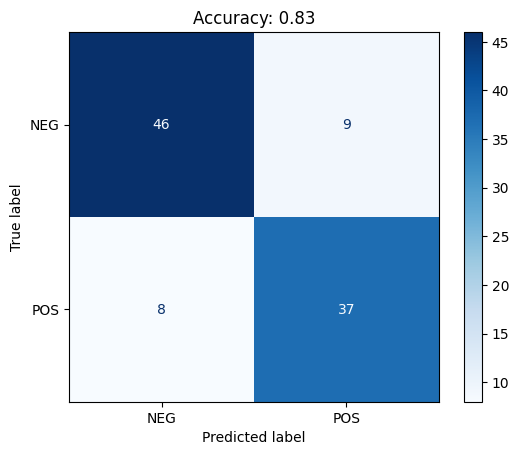

In [ ]:
confu(main_robert_model,valid_loader)

We obtained good accuracy, and the training error (blue line) decreases during training. The cross-entropy loss (red line) is noisy but shows a decreasing trend. The noise could be caused by the small number of trainable layers, but overall the results are encouraging.in same sitution that is more noisy than albert base

## Electra


downloaded tokenizer and model of electra

In [ ]:

tokenizer_electra = transformers.ElectraTokenizer.from_pretrained(
    "google/electra-base-discriminator"
)
model_electra = transformers.ElectraModel.from_pretrained(
    "google/electra-base-discriminator"
)


In [ ]:
#finally eletra model
main_electra=model(model=model_electra,tooken=tokenizer_electra,out_shape=768,n_class=2,device=device)

In [ ]:
for parameters in main_electra.parameters():
  parameters.requires_grad=False



#for parameters in main_robert.model.encoder.layer[5].intermediate.parameters():
#  parameters.requires_grad=True



#for parameters in main_robert.model.encoder.layer[7].attention.parameters():
#  parameters.requires_grad=True




for parametrs in main_electra.classifier.parameters():
  parametrs.requires_grad=True

In [ ]:
main_electra_model=main_electra.to(device)

In [ ]:
train_loss_electra,train_cross_electra=train_model(main_electra_model,train_loader,20,4,2e-5)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

epoch:0,loss:0.6941378247737885,loss_cross:0.6924295425415039
Do you want it?[y],[n],[b]n
epoch:1,loss:0.6920917183160782,loss_cross:0.6940193176269531
epoch:2,loss:0.6907610225677491,loss_cross:0.697586715221405
epoch:3,loss:0.6888992357254028,loss_cross:0.6919036507606506
epoch:4,loss:0.6866370463371276,loss_cross:0.6794255375862122
Do you want it?[y],[n],[b]n
epoch:5,loss:0.6837073618173599,loss_cross:0.661799430847168
epoch:6,loss:0.6799698990583419,loss_cross:0.6691152453422546
epoch:7,loss:0.6761042708158493,loss_cross:0.6738835573196411
epoch:8,loss:0.6690675836801528,loss_cross:0.6962844133377075
Do you want it?[y],[n],[b]y
epoch:9,loss:0.6597694075107574,loss_cross:0.6737119555473328
epoch:10,loss:0.6511543399095535,loss_cross:0.6672267317771912
epoch:11,loss:0.6346645355224609,loss_cross:0.692227303981781
epoch:12,loss:0.6213960671424865,loss_cross:0.6722329258918762
Do you want it?[y],[n],[b]y
epoch:13,loss:0.6040255758166313,loss_cross:0.5890945196151733
epoch:14,loss:0.591

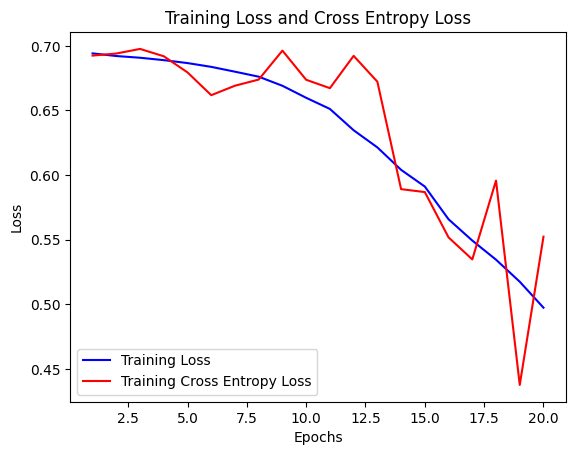

In [ ]:
show_plot(train_loss_electra,train_cross_electra)

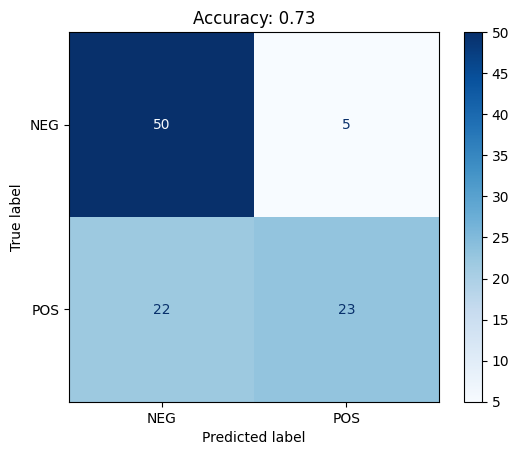

In [ ]:
confu(main_electra_model,valid_loader)

Our model’s accuracy is not significantly better compared to earlier models, but both the training error and the cross‑entropy loss (despite being somewhat noisy) show a decreasing trend during training, indicating that the model is learning over time. 


## final model


In [ ]:
patch_adres='/content/drive/MyDrive/Colab Notebooks/weights_epoch_11.pth'



In [ ]:
tookenizer_albert =transformers.AlbertTokenizer.from_pretrained("albert-base-v2")
model_albert = transformers.AlbertModel.from_pretrained("albert-base-v2")

In [ ]:
main_albert=model(model=model_albert,tooken=tookenizer_albert,out_shape=768,n_class=2,device=device)

In [ ]:
for parameters in main_albert.model.parameters():
  parameters.requires_grad=False


for parameters in main_albert.model.encoder.embedding_hidden_mapping_in.parameters():
  parameters.requires_grad=True

for parameters in main_albert.model.encoder.albert_layer_groups[0].albert_layers[0].ffn.parameters():
  parameters.requires_grad=True



for parameters in main_albert.model.encoder.albert_layer_groups[0].albert_layers[0].ffn_output.parameters():
  parameters.requires_grad=True



for parameters in main_albert.classifier.parameters():
  parameters.requires_grad=True

In [ ]:
main_albert_model=main_albert.to(device)

In [ ]:
train_loss,cross_loss=train_model(main_albert_model,train_loader,20,2,2e-5)


epoch:0,loss:0.5155176556110382,loss_cross:0.2248925417661667
Do you want it?[y],[n],[b]n
epoch:1,loss:0.3533865302056074,loss_cross:0.19405898451805115
epoch:2,loss:0.21199831172823905,loss_cross:0.09716230630874634
Do you want it?[y],[n],[b]n
epoch:3,loss:0.1340481587126851,loss_cross:0.024745602160692215
epoch:4,loss:0.08703161491081118,loss_cross:0.022263968363404274
Do you want it?[y],[n],[b]n
epoch:5,loss:0.08710991618223489,loss_cross:0.011559541337192059
epoch:6,loss:0.15692559704184533,loss_cross:0.21916325390338898
Do you want it?[y],[n],[b]n
epoch:7,loss:0.07761614031158387,loss_cross:0.11885203421115875
epoch:8,loss:0.03653816948179155,loss_cross:0.006838715169578791
Do you want it?[y],[n],[b]y
epoch:9,loss:0.014082096701022237,loss_cross:0.00373538164421916
epoch:10,loss:0.005323010771535337,loss_cross:0.0025072332937270403
Do you want it?[y],[n],[b]y
epoch:11,loss:0.0022895696910563857,loss_cross:0.002159823663532734
epoch:12,loss:0.0015927716728765518,loss_cross:0.001109

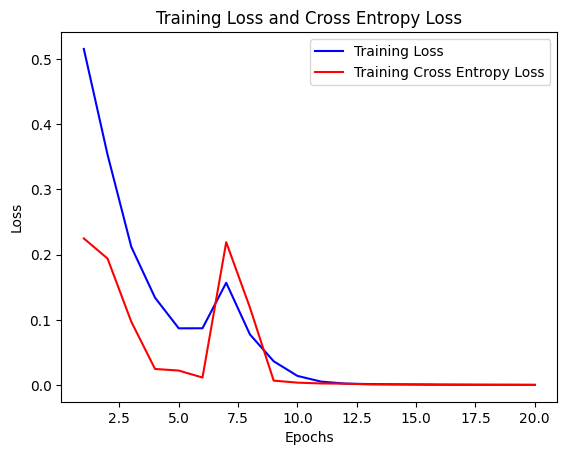

In [ ]:
show_plot(train_loss,cross_loss)

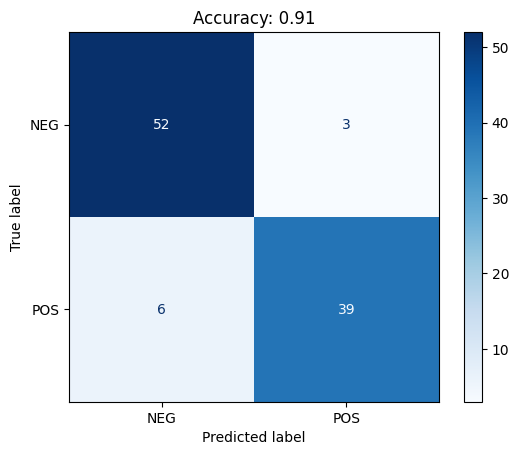

In [ ]:
confu(main_albert_model,valid_loader)

Finally, the model achieved very good accuracy. During training, the cross-entropy loss (red line) was stable and not noisy. Around epochs 6–7, the model showed minor overfitting, but the appropriate learning rate helped control it effectively. Despite this, the loss continued to decrease steadily until the end of training, indicating overall good learning progress. I believe that by removing dataset limitations and making more layers trainable, even more precise and robust results could be achieved in future training.

In [ ]:
from sklearn.metrics import f1_score,accuracy_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report


def test_model(model,loader,device):

  model.eval()
  true_labels=[]
  predicted_labels=[]

  with torch.no_grad():
    for labels,texts in loader:
      labels=labels.to(device)

      outputs=model(texts)
      predicted=torch.argmax(outputs,1)
      true_labels.extend(labels.cpu().numpy())
      predicted_labels.extend(predicted.cpu().numpy())


  f1_score_value=f1_score(true_labels,predicted_labels)
  accuracy=accuracy_score(true_labels,predicted_labels)
  precision=precision_score(true_labels,predicted_labels)
  recall=recall_score(true_labels,predicted_labels)
  report=classification_report(true_labels,predicted_labels)



  print(f"f1_score:{f1_score_value},accuracy:{accuracy},precision:{precision},'recall':{recall}")
  print(50*'- ')
  print(report)

In [ ]:
test_model(main_albert_model,test_loader,device)

f1_score:0.9069767441860465,accuracy:0.92,precision:0.9512195121951219,'recall':0.8666666666666667
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
              precision    recall  f1-score   support

           0       0.90      0.96      0.93        55
           1       0.95      0.87      0.91        45

    accuracy                           0.92       100
   macro avg       0.92      0.92      0.92       100
weighted avg       0.92      0.92      0.92       100

